In [1]:
from app.dotenv import base_dir, data_dir
import os, numpy as np
import pandas as pd; 

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('base_dir:', base_dir)
print('data_dir:', data_dir)
# print('dotenv params:', {os.getenv('PARAM1')})


base_dir: /Users/yishai/Desktop/RecipeSimilarity/app
data_dir: /Users/yishai/Desktop/RecipeSimilarity/data


download and parse dataset

In [2]:
from app.load_dataset import download_zip,parse_json,print_recipe


# Check if the file already exists, if not download it
if not os.path.exists(f'{data_dir}/recipes_raw.zip'):# 
    download_zip(data_dir,url = 'https://eightportions.com/recipes_raw.zip')
data = parse_json(zip_file_path = f'{data_dir}/recipes_raw.zip')



for recipe_id, recipe in data.items():
    recipe_series = pd.Series(recipe)

    # recipes_df = pd.DataFrame.from_dict(recipe, orient='index')
    print_recipe(recipe_series)
    break


dict_keys(['title', 'ingredients', 'instructions', 'picture_link', 'website'])
recipes_raw_nosource_ar.json len: 100
total data len: 100
dict_keys(['ingredients', 'picture_link', 'instructions', 'title', 'website'])
recipes_raw_nosource_epi.json len: 100
total data len: 200
dict_keys(['instructions', 'ingredients', 'title', 'picture_link', 'website'])
recipes_raw_nosource_fn.json len: 100
total data len: 300
Title: Slow Cooker Chicken and Dumplings
Ingredients:
 - 4 skinless, boneless chicken breast halves ADVERTISEMENT
 - 2 tablespoons butter ADVERTISEMENT
 - 2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT
 - 1 onion, finely diced ADVERTISEMENT
 - 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT
 - ADVERTISEMENT
Instructions:
Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slo


Standardize data: implement a better structured data model that can accommodate the various attributes of recipes using the above dataset
1. Ensure that each recipe follows the same structure (represented with consistent fields)
2. drop recipes without instructions
3. Flatten ingredients list into separate keys (number of columns according to max value in data)
4. Convert into dataframe (each key into column, each recipe into new row)

In [3]:
from app.preprocess import standardize

df,ingredients_columns = standardize(data.copy(),list(data[0].keys()))

print_recipe(df.loc[0])
df.columns



ingredients max num: 55
fields which may have null value: ['picture_link']
recipes without instructions (removed from data): []
recipes without ingredients (removed from data): [281]
Title: Slow Cooker Chicken and Dumplings
Ingredients:
Instructions:
Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

Picture Link: 55lznCYBbs2mT8BTx6BTkLhynGHzM.S
Website: ar

----------------------------------------



Index(['title', 'instructions', 'picture_link', 'website', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52',
       '53', '54'],
      dtype='object')

Normalize Text: 
   1. clean_text: 
       1. remove encoding characters like \xad, \u00ad, seperate punctuation, 
       2. remove words like 'ADVERTISEMENT' and other non-recipe related terms
       3. converting to lower case
       4. remove leading/trailing whitespaces.
   2. split_number_and_word: split a word containing a number and a word (take1.2 -> take 1.2)
   3. split_un_words: split words starting with 'un' into 'un' and the rest of the word ('unsalted' becomes ['un', 'salted']).

In [4]:

from app.preprocess import normalize_text
df = normalize_text(df.copy(), df.columns)

# df = df[['0']]
print(df.columns)
# df.columns




Index(['title', 'instructions', 'picture_link', 'website', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52',
       '53', '54'],
      dtype='object')


extract entities from the ingredients sentences:
1. extract ingredients (2 teaspoons of salt -> salt is the ingredient)
2. extract units in data and their transformation 
   1. example: teaspoon is a volume unit, all volume units are transformed into cups )
3. convert values in text into numeric values (¼ -> 0.25, )
4. extract numeric values in text (2 teaspoons the value is 2)
5. transform values (2 teaspoons are transformed into cups)
6. rows with no units and values are seasoning and ignored (such as: add salt and pepper by taste)

output: for each ingredient a column with amount and unit; before and after the conversion

left to do: 
1. when theres 1¼ instead of output 1.25 there is [1,0.25]
   a. fix: when converting into numeric values  - search for close value and add it (1+0.25)
2. when having more than 1 value/unit output (example: 2 cans where each is 10 oz)
   1. according to proximity find relations to ingredient (noun) and take the correct value

In [5]:
from app.extract_entities.amounts import extract_entities,measurement_units,nlp
df = extract_entities (df.copy(),ingredients_columns)

print('sentence:', df['0'].loc[1])
print('amounts',df['0_amount'].loc[1])
print('ingredients:', df['0_ingredients'].loc[1])

sentence: 2 ( 10.75 ounce ) cans condensed cream of mushroom soup
amounts {'0_units_orig': ['ounce'], '0_units_converted': ['cup'], '0_amount_orig': [2.0, 10.75], '0_amount_converted': 0.25}
ingredients: ['cream', 'mushroom', 'soup']


todo: create back text from entities

In [ ]:
def append_ingrediants(row):
    return row['0_amount'] + ' ' + row['0_ingredients']
for column in ingredients_columns:
    df[column] = df.apply(lambda row: append_ingrediants(df[f'{column}_amount'], df[f'{column}_ingredients']), axis=1)
    df['result'] = df.apply(lambda row: append_ingrediants(df[f'{column}_amount'], df[f'{column}_ingredients']) 
                            if pd.notna(row['col1']) else (row['col2']  else None),axis=1)



In [ ]:
merge data:
    for each row in df:
        find which ingredints columns are not empty
        for each ingredin:
            merge ingredints, amounts, units
            append to total_ingredients
    drop all ingredints columns
    drop all rows except total_ingredients,title and instructions
         

In [ ]:
# # Example recipe descriptions for 3 recipes
# data1 = [
#     "1 teaspoon salt, 2 cups flour, 1 cup sugar, bake at 350°F",  # ingredients
#     "Chocolate Cake",                                            # title
#     "Mix ingredients, bake at 350°F",                            # instructions
# ]

# data2 = [
#     "2 teaspoons vinegar, 1.5 cups flour, 1 cup sugar, bake at 350°F",  # ingredients
#     "Chocolate Cake",                                                 # title
#     "Mix ingredients, bake at 350°F",                                 # instructions
# ]

# data3 = [
#     "1 tablespoon salt, 3 cups flour, 1.5 cups sugar, bake at 375°F",  # ingredients
#     "Vanilla Cake",                                                  # title
#     "Mix ingredients, bake at 375°F",                                 # instructions
# ]

# # List of data sets for 3 recipes
# data_sets = [data1, data2,data3]

# # Example of weights for each component of the data (ingredients, title, and instructions)

Similarity Calculation and Visualization

1. Similarity Metrics - composed of 3 parts:
    1. Cosine Similarity: Measures the cosine of the angle between two vectors. 
    2. Embeddings: vectors are represention of each recipe parts (ingredients, instructions, titles), using Sentence Embeddings (via SBERT model).
    3. Weighted Similarity: Combines different recipe parts similarity with weights to give more importance to certain parts of the recipe.
2. Visualization: heatmap is generated to visually compare similarities between multiple recipes based on the metrics above.

Similarity Matrix:
[[1.00000004 0.91102347 0.88791271]
 [0.91102347 1.00000021 0.82112558]
 [0.88791271 0.82112558 1.        ]]


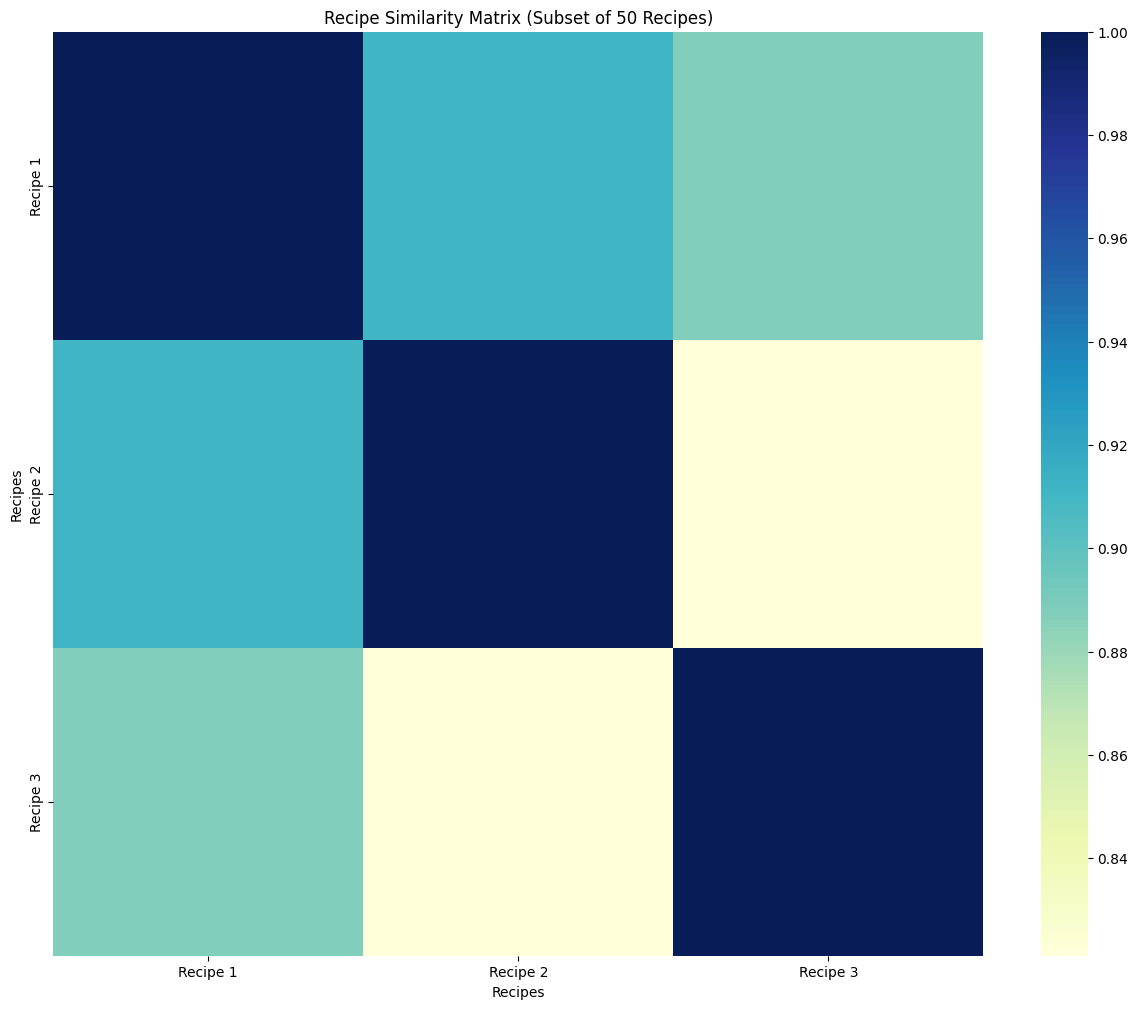

In [ ]:
from app.similarity.compute import compute_similarity_matrix
from app.similarity.plot import plot_heatmap



# Compute the similarity matrix for the 3 recipes
weights = [0.5, 0.3, 0.2]  # For ingredients, title, and instructions
similarity_matrix = compute_similarity_matrix(data_sets, weights)

# Generate a 1000x1000 similarity matrix - for testing purposes
# similarity_matrix = generate_dummy_matrix(size=1000)
plot_heatmap(similarity_matrix, labels=None)

print("Similarity Matrix:")
print(similarity_matrix)

In [ ]:
# import pandas as pd
# from collections import Counter

# # Function to get unique words sorted by frequency
# def get_unique_words(df, columns):
#     # Combine all sentences into a single string and convert to lowercase
#     text = ''
#     for column in columns:
#         text += ' '.join(df[column].loc[df[column].notnull()])
    
#     # Split the text into words
#     words = text.split()

#     # Remove digits from the list of words
#     def isDigit(x):
#         try:
#             float(x)
#             return True
#         except ValueError:
#             return False
#     words = [word for word in words if not isDigit(word) ]#word.isdigit()
    
#     # Count the frequency of each word using Counter
#     word_counts = Counter(words)
    
#     # Sort words by frequency in descending order
#     sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
#     # Return a list of words sorted by frequency
#     return sorted_words
# unique_words = get_unique_words(df, columns = [i for i in df.columns if 'ingredients' in i])
# # unique_words = get_unique_words(df,[col for col in df.columns if 'ingredients' in col] )#['instructions','ingredients_1']




TypeError: sequence item 0: expected str instance, list found

In [ ]:

import re

def remove_extraneous_info(text):
    """
    Remove words like 'ADVERTISEMENT' and other non-recipe related terms.
    """
    return re.sub(r'\bADVERTISEMENT\b', '', text, flags=re.IGNORECASE).strip()